In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import category_encoders as ce
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

pd.set_option('display.max_columns', None)

In [2]:
# took from: https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations

def compute_recall_at4(y_true: np.array, y_pred: np.array) -> float:
    
    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos
    
    # desc sorting by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]
    
    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    
    # default rate captured at 4%
    d = target[four_pct_mask].sum() / n_pos
    
    return d

def compute_normalized_gini(y_true: np.array, y_pred: np.array) -> float:
    
    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting desc by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]

    # weighted gini coefficient
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()

    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max
    
    return g
    
def compute_amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting desc by prediction values
    indices = np.argsort(y_pred)[::-1]
    target = y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [3]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

this baseline uses this dataset: https://www.kaggle.com/datasets/mavillan/amex-data-integer-dtypes-aggregated/ which is an aggregated version of this one: https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format. The code used to generate the aggregated dataset can be found here: https://www.kaggle.com/code/mavillan/amex-preproc-features.

***
## load and prepare data

In [4]:
train_agg = pd.read_parquet("../input/amex-data-integer-dtypes-aggregated/train_agg.parquet")

train_labels = pd.read_csv("../input/amex-default-prediction/train_labels.csv")
train_labels["customer_ID"] = train_labels["customer_ID"].str[-16:].apply(lambda x: int(x,16))
train_labels.set_index("customer_ID", inplace=True)

In [5]:
input_feats = train_agg.columns.tolist()
categ_feats = [
    'B_30_last', 'B_38_last', 'D_114_last', 'D_116_last', 'D_117_last', 
    'D_120_last', 'D_126_last', 'D_63_last', 'D_64_last', 'D_66_last', 'D_68_last',
]

In [9]:
train_agg = pd.merge(train_agg, train_labels, how="inner", left_index=True, right_index=True)
train_agg.reset_index(drop=True, inplace=True)

del train_labels
gc.collect()

30

***
## model training

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2112)
skf_split = list(skf.split(train_agg, train_agg["target"].values))

In [12]:
model_params = {
    'objective': 'binary',
    'metric': 'None',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 2112,
    'verbosity': 0,
    'first_metric_only': True,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.2,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'min_data_in_leaf': 1000,
    'path_smooth': 10,
    'max_bin': 255,
}

######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.766817	valid_0's recall_at4: 0.621518	valid_0's norm_gini: 0.912115
[100]	valid_0's amex_metric: 0.781003	valid_0's recall_at4: 0.643609	valid_0's norm_gini: 0.918398
[150]	valid_0's amex_metric: 0.786222	valid_0's recall_at4: 0.651098	valid_0's norm_gini: 0.921346
[200]	valid_0's amex_metric: 0.789536	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.922715
[250]	valid_0's amex_metric: 0.790828	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.92349
[300]	valid_0's amex_metric: 0.791925	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923873
[350]	valid_0's amex_metric: 0.792365	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924122
[400]	valid_0's amex_metric: 0.79287	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.924333
[450]	valid_0's amex_metric: 0.792467	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.92441
Early stopping, best iteration is:
[390]	valid_0's 

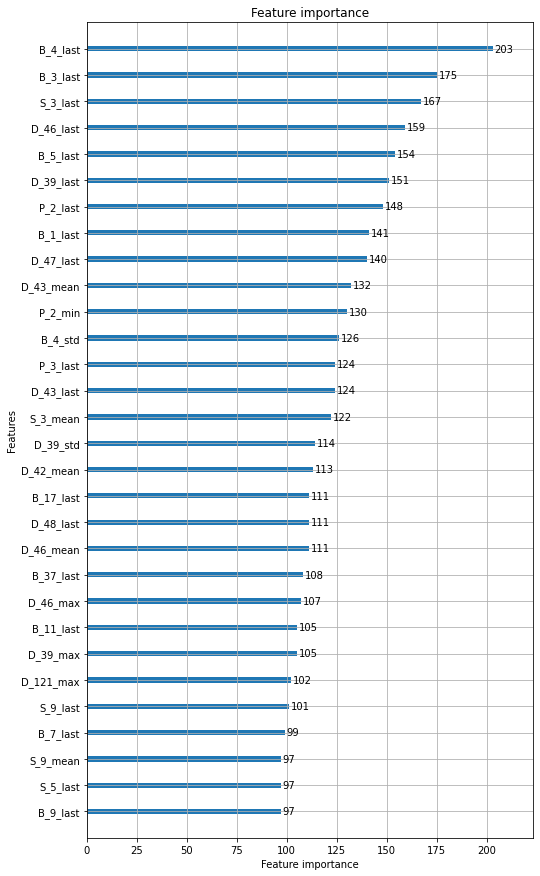

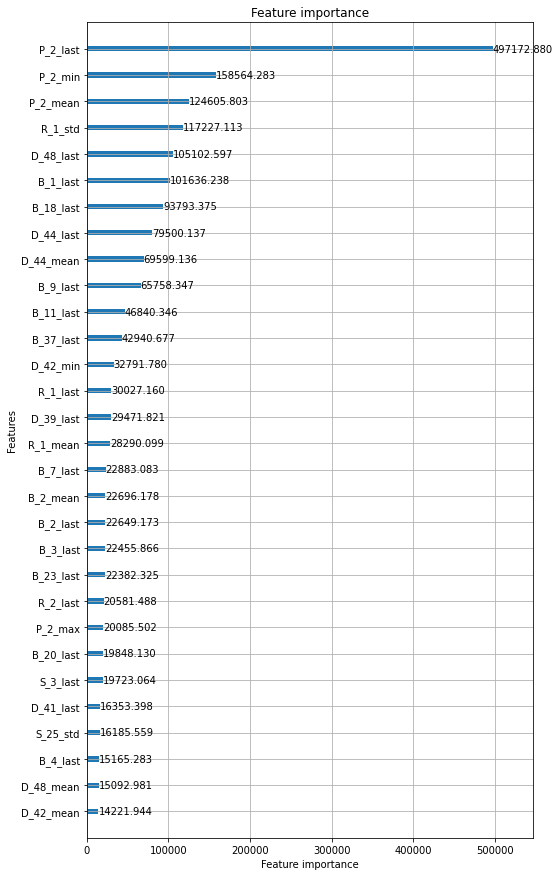

######################################## training model 2/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.762285	valid_0'

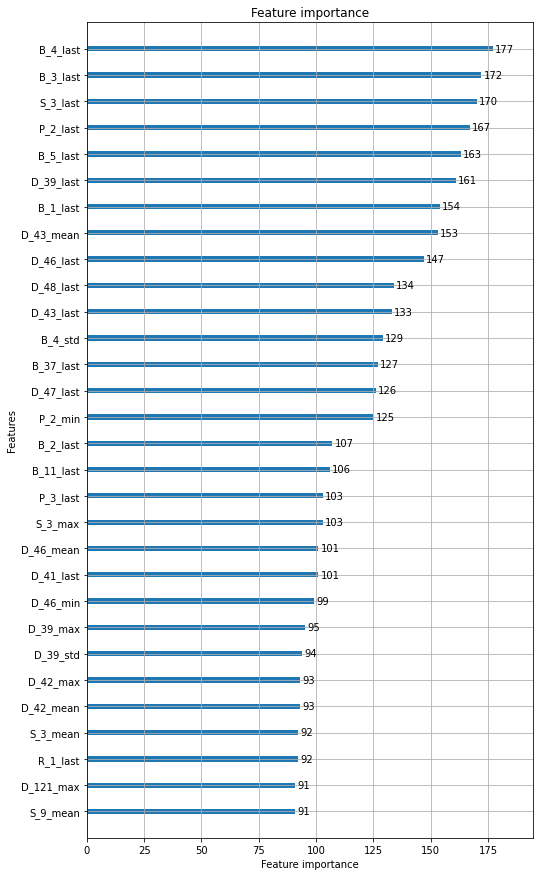

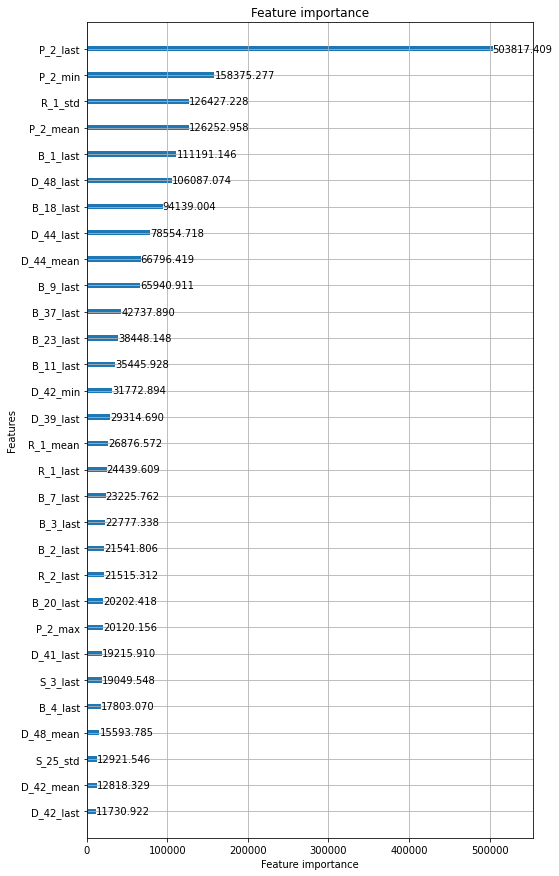

######################################## training model 3/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.768654	valid_0'

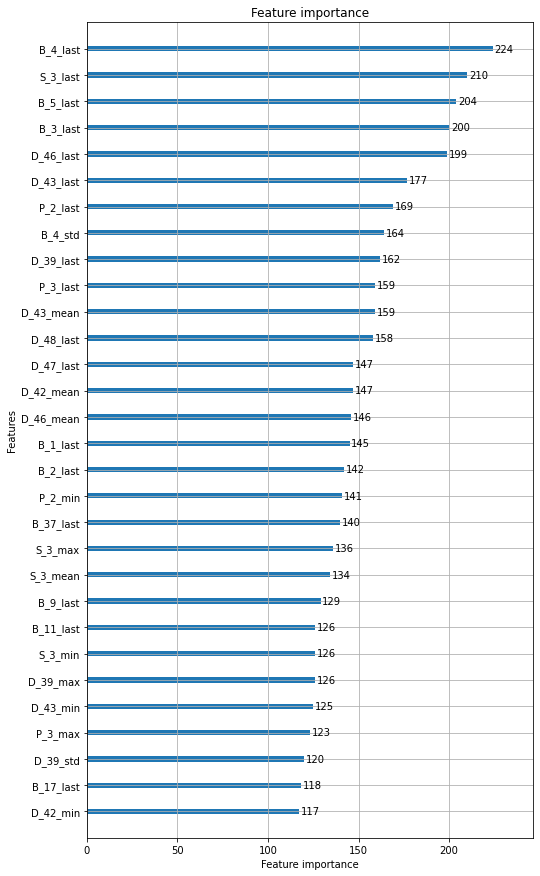

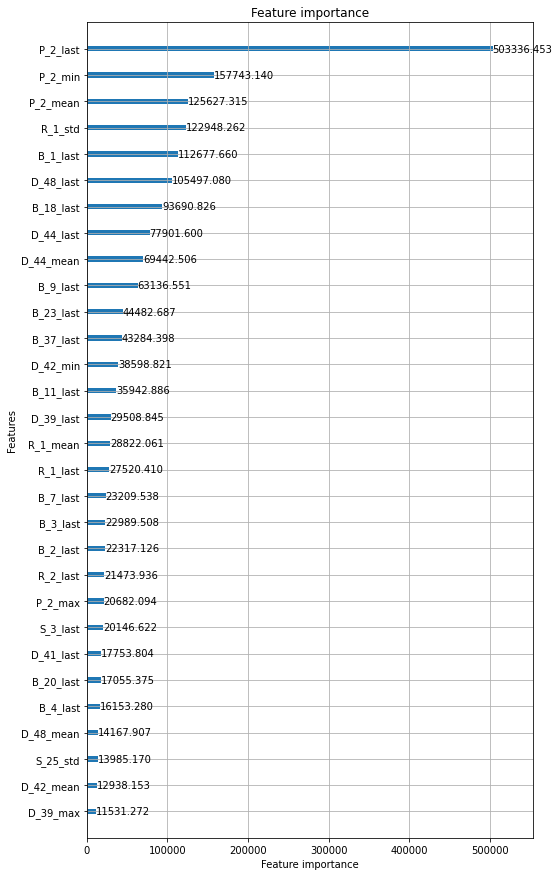

######################################## training model 4/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.7652	valid_0's 

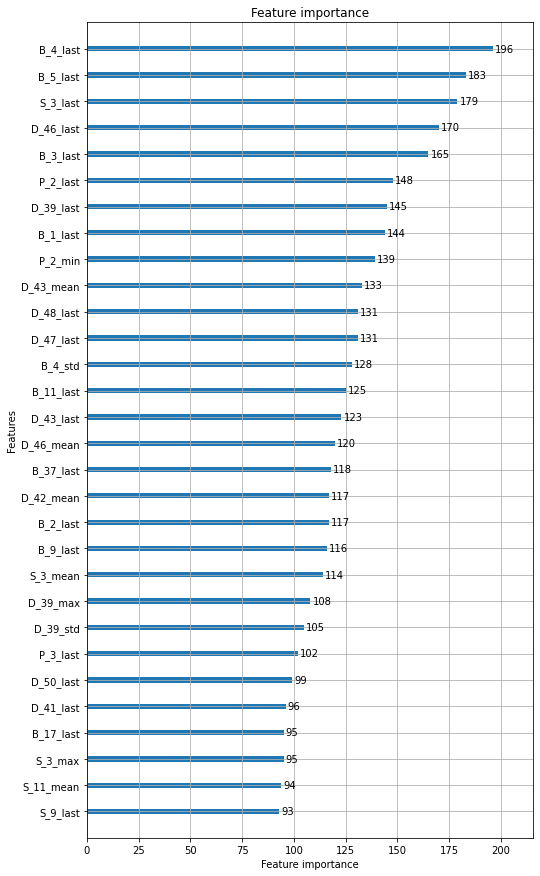

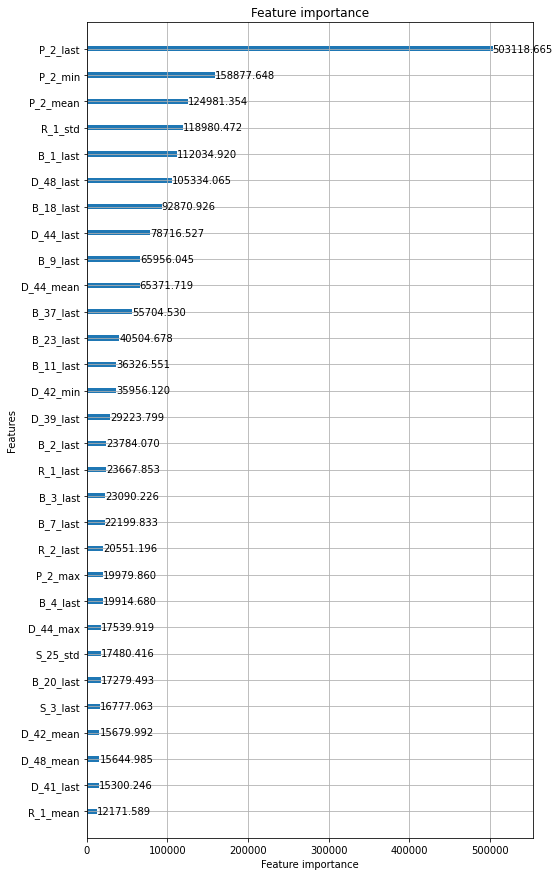

######################################## training model 5/5 ########################################
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
Training until validation scores don't improve for 100 rounds
[50]	valid_0's amex_metric: 0.770598	valid_0'

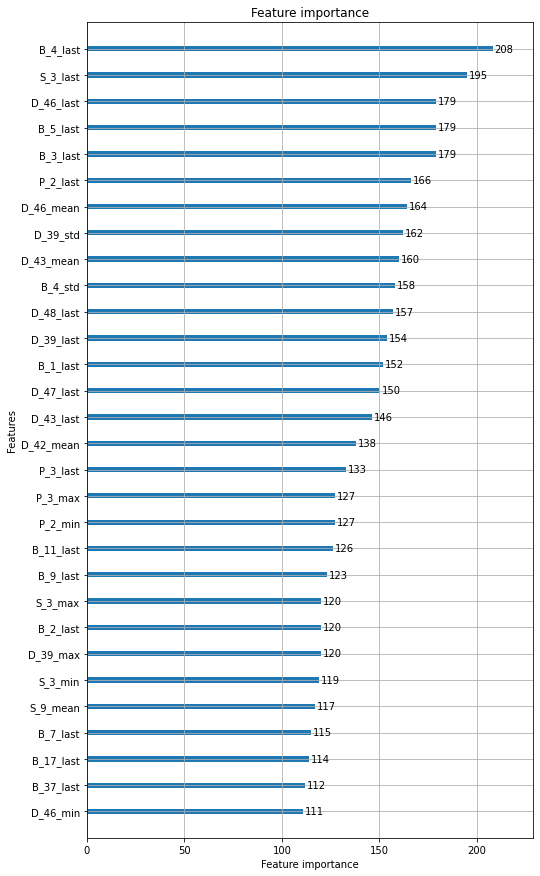

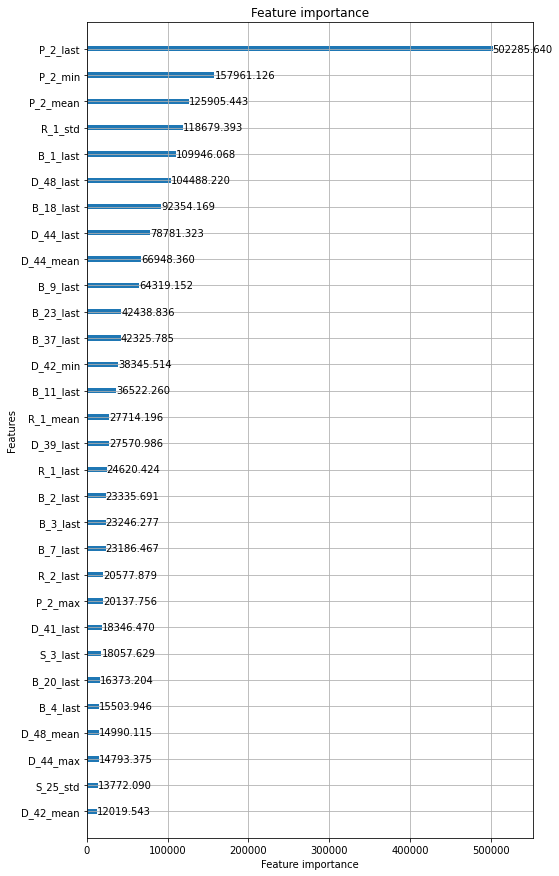

CPU times: user 55min 46s, sys: 28.5 s, total: 56min 15s
Wall time: 16min 24s


In [13]:
%%time
models = list()

# dataframe to store the oof predictions
oof = train_agg[["target"]].copy()
oof["pred"] = -1

for fold,(train_idx,valid_idx) in enumerate(skf_split):
    
    print(f" training model {fold+1}/{len(skf_split)} ".center(100, "#"))
    
    train_dset = lgb.Dataset(
        data=train_agg.loc[train_idx,input_feats],
        label=train_agg.loc[train_idx,"target"].values,
        categorical_feature=categ_feats,
        free_raw_data=True
    )
    valid_dset = lgb.Dataset(
        data=train_agg.loc[valid_idx,input_feats],
        label=train_agg.loc[valid_idx,"target"].values,
        categorical_feature=categ_feats,
        free_raw_data=True
    )
    
    model = lgb.train(
        params=model_params,
        train_set=train_dset,
        valid_sets=[valid_dset,],
        feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
        num_boost_round=3000,
        callbacks=[lgb.log_evaluation(period=50), lgb.early_stopping(100)],
    )
    model.save_model(f"model_lgb_{fold}.txt")
    
    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()
    
    oof.loc[valid_idx,"pred"] = model.predict(train_agg.loc[valid_idx,input_feats])
        
    models.append(model)
    del train_dset,valid_dset
    gc.collect()

In [14]:
# oof metrics
print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))

OOF recall_at4: 0.66246170936143
OOF normalized_gini: 0.9233627301373251
OOF competition metric: 0.7929122197493775


In [15]:
del train_agg
gc.collect()

46

***
## make predictions and submit

In [16]:
test_agg = pd.read_parquet("../input/amex-data-integer-dtypes-aggregated/test_agg.parquet")

In [ ]:
%%time
preds = [model.predict(test_agg[input_feats]) for model in models]
test_agg["prediction"] = np.mean(preds, axis=0)

In [ ]:
sample_sub = pd.read_csv("../input/amex-default-prediction/sample_submission.csv")
sample_sub

In [ ]:
sub = pd.merge(sample_sub[["customer_ID"]], test_agg[["customer_ID","prediction"]])

In [ ]:
assert sub.prediction.isna().sum() == 0

In [ ]:
sub.to_csv("submission.csv", index=False)

***